In [16]:
#Trains many neural networks in order to create a data set of weights
#uses the same algorithm as Spins_cross
#Testing performance by variating learning rules and cost functions
import pickle
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.datasets import mnist

ModuleNotFoundError: No module named 'keras'

In [2]:
#for i in range(0,3):
#    plt.savefig('asd'+str(i))

In [3]:
def load_pickle(pickle_file):
    try:
        with open(pickle_file, 'rb') as f:
            pickle_data = pickle.load(f)
    except UnicodeDecodeError as e:
        with open(pickle_file, 'rb') as f:
            pickle_data = pickle.load(f, encoding='latin1')
    except Exception as e:
        print('Unable to load data ', pickle_file, ':', e)
        raise
    return pickle_data

with open('spins_nConfig4600.p', 'rb') as f:
    data = pickle.load(f)

temp = load_pickle('temperatures_nConfig4600.p')


In [4]:
n_config=np.shape(data)[0]
n_spins=len(data[0,:])

print(n_config)
print(n_spins)

M=[] #stores the total (scaled) magnetization of each configuration in terms of temperature

#calculates magnetization for each configuration
for i in range(0,n_config):
    m=0
    m=np.sum(data[i,:])/n_spins    
    M.append(m)

labels_T=np.zeros((len(temp),2)) 

#asigns label with respect to critical temperature
def T_labels(Ma,Te,crit,labels):
    T=np.array(Te)
    M = np.array(Ma)
    ii= T< crit
    jj = T>=crit
    #under Tc
    labels[ii,:]=[0,1]
    labels[jj,:]=[1,0]
    return T[ii], M[ii], T[jj], M[jj]
    
Tc=2.2691853

T_small, M_small, T_big, M_big = T_labels(M, temp, Tc,labels_T)

4600
1024


In [5]:
data = pd.DataFrame(data)
temp = pd.DataFrame(temp,columns=['T'])
data_withT = pd.concat([data,temp],axis=1)

In [6]:
#creates a train test split delete if you have another data set
X_trainT, X_testT, y_train, y_test = train_test_split(data_withT,labels_T,test_size=0.3,random_state=101)

In [7]:
X_train=X_trainT.drop('T', axis=1)
X_test = X_testT.drop('T', axis=1)

In [8]:
#CREATES THE ARCHITECTURE


n_labels=2 #there will be one output neuron for each label
hidden=50 #number of hidden units
size=n_spins #system size

#initializes weights
def weig(shape):
    first= tf.random_normal(shape,stddev=0.2)
    return tf.Variable(first)

#initializes bias
def bi(shape):
    first = tf.constant(np.random.rand(), shape=shape)
    return tf.Variable(first)

#defines the output function of each neuron in the layer
def layers(x, W,b):
  return tf.nn.sigmoid(tf.matmul(x, W)+b)

#Now we create the model with the input vector and teacher vector. This is the input layer
x = tf.placeholder("float", shape=[None, size])
y = tf.placeholder("float", shape=[None, n_labels]) #teacher vector = label


#defining the hidden layer
W_1 = weig([size,hidden])
b_1 = bi([hidden])
lay_1 = layers(x, W_1,b_1)
#Output layer
W_2 = weig([hidden,n_labels])
b_2 = bi([n_labels])
y_hat=layers(lay_1, W_2,b_2) #our predicted value

#Defining the cost function
error = tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=y_hat)

#adds an  regularization term to with a beta value
beta =0.01 #for L2
alpha=0.002 #for L1

error = tf.reduce_mean(error + beta *( tf.nn.l2_loss(W_1)+tf.nn.l2_loss(W_2)))

optimizer = tf.train.AdamOptimizer(0.001)
train = optimizer.minimize(error)


#predictions
correct_prediction = tf.equal(tf.argmax(y_hat,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))



In [9]:
saver2= tf.train.Saver()

0
step 0, training accuracy 0.403106
INFO:tensorflow:Restoring parameters from /Users/rasputin/Desktop/Uni/Tesis/Ising_NN/Models/L2/das_data/ising50_0.ckpt
evaluation accuracy= 0.57463765
1


TypeError: 'Series' objects are mutable, thus they cannot be hashed

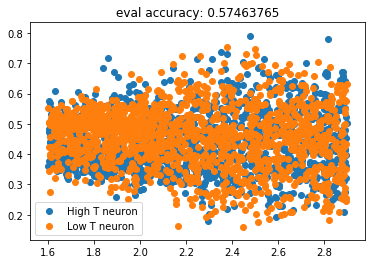

In [10]:
for ii in range(0,2):
    print(ii)
    out=np.zeros(shape=(len(temp),n_labels))
    outav=np.zeros(shape=(len(temp)))
    outac = np.zeros(shape=(len(temp)))
    evolve_acc = []

#starting a session 
    init = tf.global_variables_initializer()
    with tf.Session() as sess:
    
        sess.run(init)
    
        epochs = 3
    #training cycle
    
        for i in range(epochs):
            train_accuracy = sess.run(accuracy,feed_dict={ x:X_train, y: y_train})      
            sess.run(train,feed_dict={x:X_train, y:y_train})#feeding data to the place holders 
        #stops training when accuracy crosses a certain threshold
            if i%50 == 0:
                evolve_acc.append(train_accuracy)
                print ("step %d, training accuracy %g"%(i, train_accuracy))
            if(train_accuracy>=0.95):
                print(train_accuracy)
                print(i)
                break;
    
        #now let's try checking the neuron outputs for each temperature
        out=(sess.run(y_hat,feed_dict={x:X_train, y:y_train}))
        for i in range(len(temp)):
            res=sess.run(y_hat,feed_dict={x: X_train, y: y_train})
        
        outav=res #neuron outputs
        saver2.save(sess, '/Users/rasputin/Desktop/Uni/Tesis/Ising_NN/Models/L2/das_data/ising50_'+str(ii)+'.ckpt')
        
        #evaluation and output
    with tf.Session() as sess:
    #restores the model
        saver2.restore(sess, '/Users/rasputin/Desktop/Uni/Tesis/Ising_NN/Models/L2/das_data/ising50_'+str(ii)+'.ckpt')
        for i in range(len(y_test)):
            output= sess.run(y_hat,feed_dict={x:X_test})
        eval_accur=accuracy.eval({ x: X_test, y:y_test})
        print('evaluation accuracy=', eval_accur  )

        h_w, o_w= sess.run([W_1,W_2],feed_dict={x:X_test})

    x=X_testT['T']
    plt.scatter(x, output[:,0], label= 'High T neuron')
    plt.scatter(x, output[:,1], label= 'Low T neuron')
    plt.legend()
    plt.title('eval accuracy: '+ str(eval_accur))
    plt.savefig('eval_performance_50_'+str(ii)+'.pdf')

    weigth_out=pd.DataFrame(h_w)
    weigth_out.to_csv('W_50_'+str(ii)+'.csv')

    out_out=pd.DataFrame(o_w)
    out_out.to_csv('O_50_'+str(ii)+'.csv')

    n_output = pd.DataFrame(output)
    n_output.to_csv('n_50_'+str(ii)+'.csv')
    true_out= pd.DataFrame(y_test)
    true_out.to_csv('true_50_'+str(ii)+'.csv')

    acc_out=pd.DataFrame(evolve_acc)
    acc_out.to_csv('acc_cross_entropy_50_'+str(ii)+'.csv')